In [319]:
import os
import pandas as pd
import numpy as np
import six
import xarray as xr
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import dates

from stompy import utils
from stompy import filters
from stompy.io.local import noaa_coops
from stompy.model.suntans import sun_driver
from stompy import xr_utils
from stompy.grid import unstructured_grid
from stompy.plot import plot_utils
from stompy.spatial import field, proj_utils 
%matplotlib notebook

In [110]:
six.moves.reload_module(noaa_coops)


<module 'stompy.io.local.noaa_coops' from '/home/rusty/src/stompy/stompy/io/local/noaa_coops.py'>

In [2]:
cache_dir="cache"
os.path.exists(cache_dir) or os.makedirs(cache_dir)
fig_dir="figs-20190618"
os.path.exists(fig_dir) or os.makedirs(fig_dir)

In [581]:
six.moves.reload_module(sun_driver)
modelA=sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_009-20170901/")
modelA.projection="EPSG:26910"
start=np.datetime64("2017-07-01") # 1 month spinup
end  =modelA.run_stop

fig_dir=os.path.join(modelA.run_dir,'figs-20190621')
os.path.exists(fig_dir) or os.makedirs(fig_dir)

INFO:DFlowModel:Will read cell depths, too


In [582]:
def noaa_water_level(station,start,stop,**kw):
    ds=noaa_coops.coops_dataset_product(station=station,product='water_level',
                                        start_date=start,end_date=stop,
                                        cache_dir=cache_dir,clip=True)
    ds=ds.set_coords(['lon','lat'])
    da=ds.water_level.isel(station=0)
    da.attrs.update(kw)
    return da
alameda_wl=noaa_water_level(9414750,start,end,name="NOAA Alameda")
pointreyes_wl=noaa_water_level(9415020,start,end,name="NOAA Point Reyes")
sanfran_wl=noaa_water_level(9414290,start,end,name="NOAA Fort Point")
coyote_wl=noaa_water_level(9414575,start,end,name="NOAA Coyote Creek")
richmond_wl=noaa_water_level(9414863,start,end,name="NOAA Richmond")
portchicago_wl=noaa_water_level(9415144,start,end,name="NOAA Port Chicago")


INFO:noaa_coops:Cached   2017-07-01 00:00:00 -- 2017-08-01 00:00:00
INFO:noaa_coops:Cached   2017-08-01 00:00:00 -- 2017-09-01 00:00:00
INFO:noaa_coops:Cached   2017-09-01 00:00:00 -- 2017-10-01 00:00:00
INFO:noaa_coops:Cached   2017-10-01 00:00:00 -- 2017-11-01 00:00:00
INFO:noaa_coops:Cached   2017-07-01 00:00:00 -- 2017-08-01 00:00:00
INFO:noaa_coops:Cached   2017-08-01 00:00:00 -- 2017-09-01 00:00:00
INFO:noaa_coops:Cached   2017-09-01 00:00:00 -- 2017-10-01 00:00:00
INFO:noaa_coops:Cached   2017-10-01 00:00:00 -- 2017-11-01 00:00:00
INFO:noaa_coops:Cached   2017-07-01 00:00:00 -- 2017-08-01 00:00:00
INFO:noaa_coops:Cached   2017-08-01 00:00:00 -- 2017-09-01 00:00:00
INFO:noaa_coops:Cached   2017-09-01 00:00:00 -- 2017-10-01 00:00:00
INFO:noaa_coops:Cached   2017-10-01 00:00:00 -- 2017-11-01 00:00:00
INFO:noaa_coops:Cached   2017-07-01 00:00:00 -- 2017-08-01 00:00:00
INFO:noaa_coops:Cached   2017-08-01 00:00:00 -- 2017-09-01 00:00:00
INFO:noaa_coops:Cached   2017-09-01 00:00:00 -- 

In [265]:
from stompy.model import data_comparison
six.moves.reload_module(data_comparison)

<module 'stompy.model.data_comparison' from '/home/rusty/src/stompy/stompy/model/data_comparison.py'>

<IPython.core.display.Javascript object>


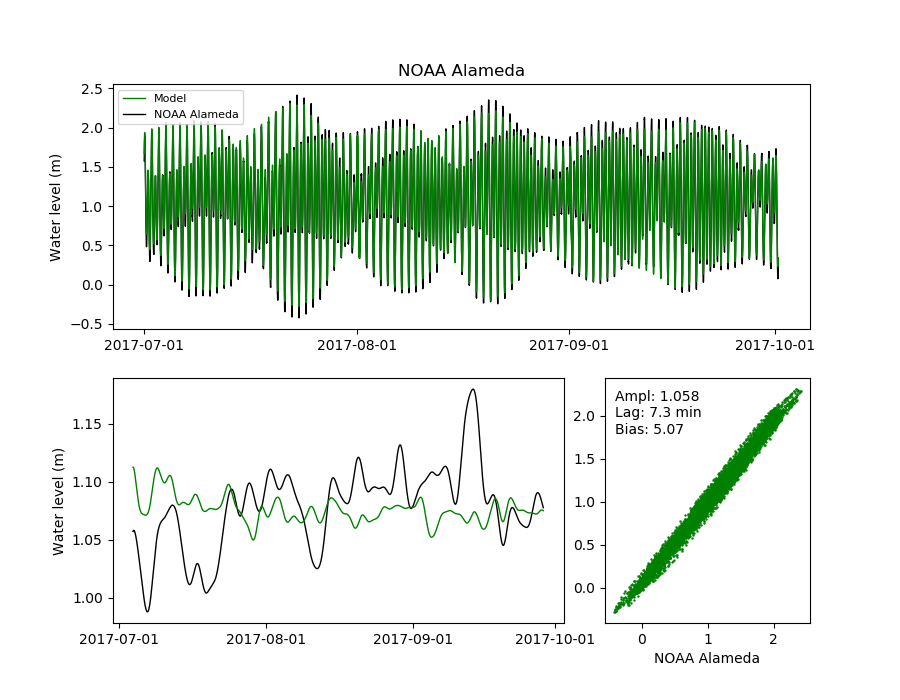

<IPython.core.display.Javascript object>


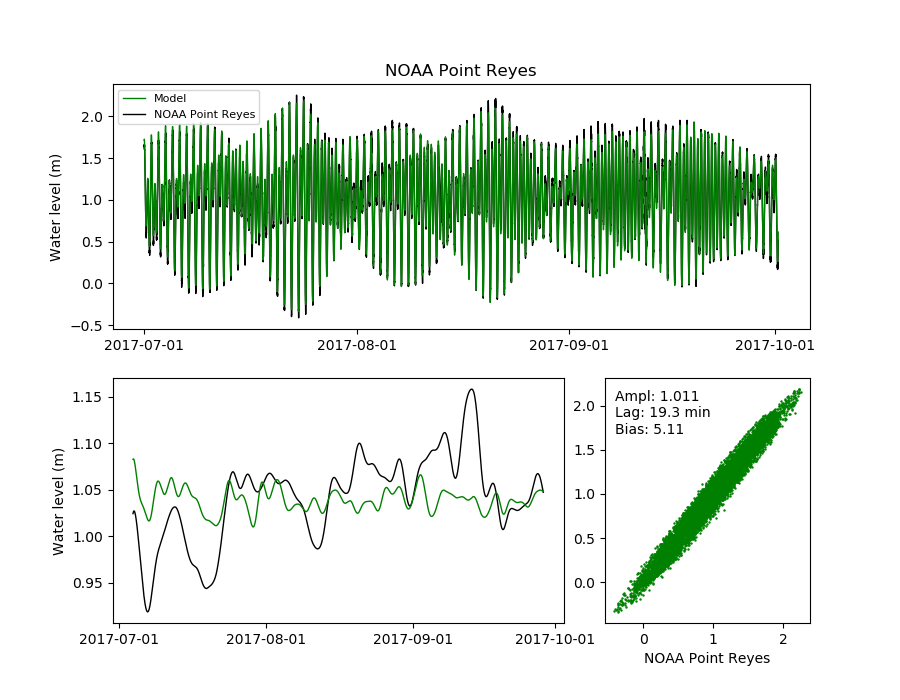

<IPython.core.display.Javascript object>


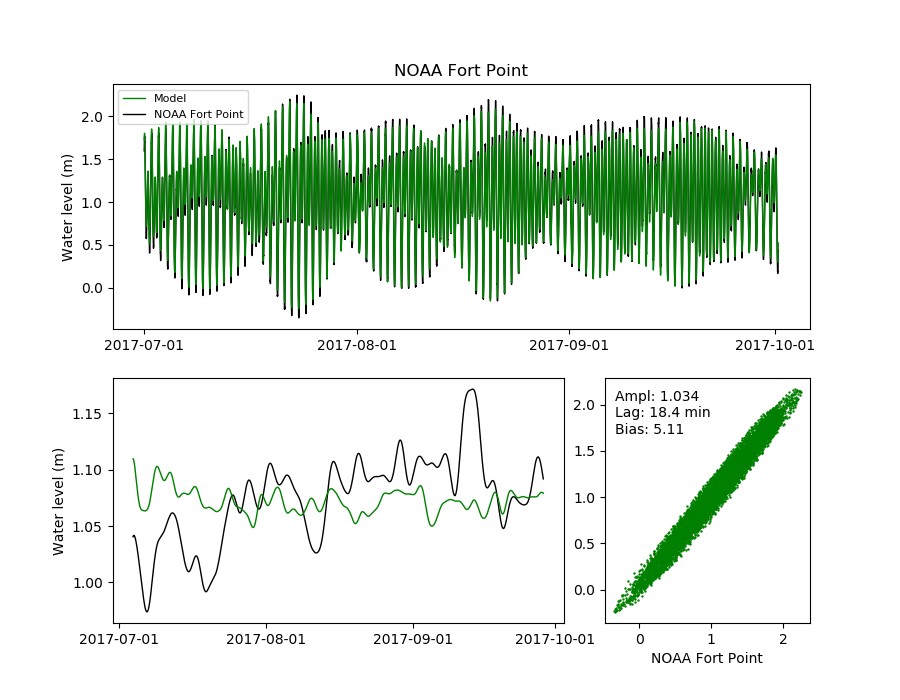

<IPython.core.display.Javascript object>


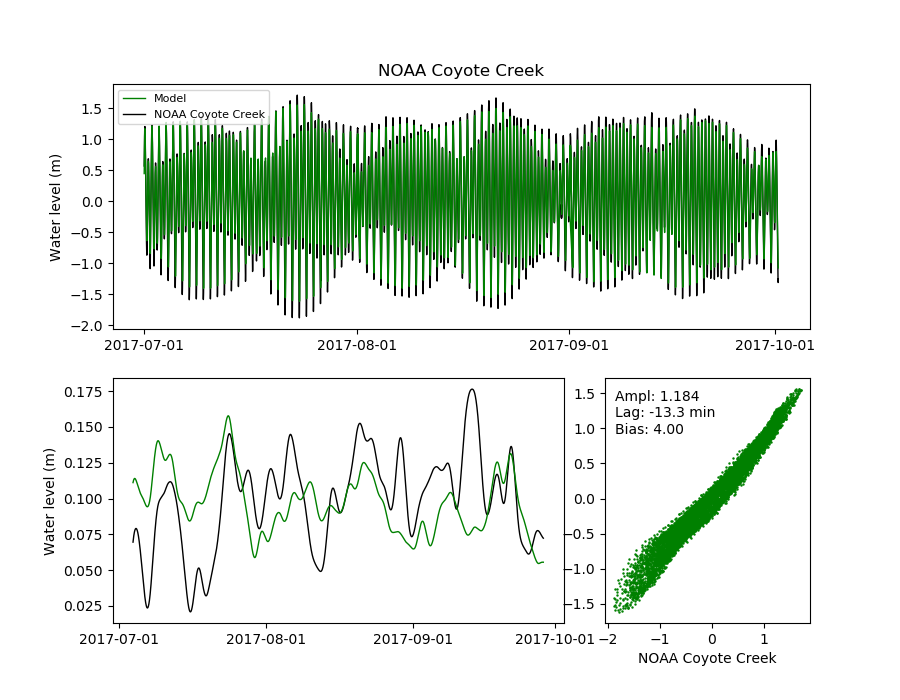

<IPython.core.display.Javascript object>


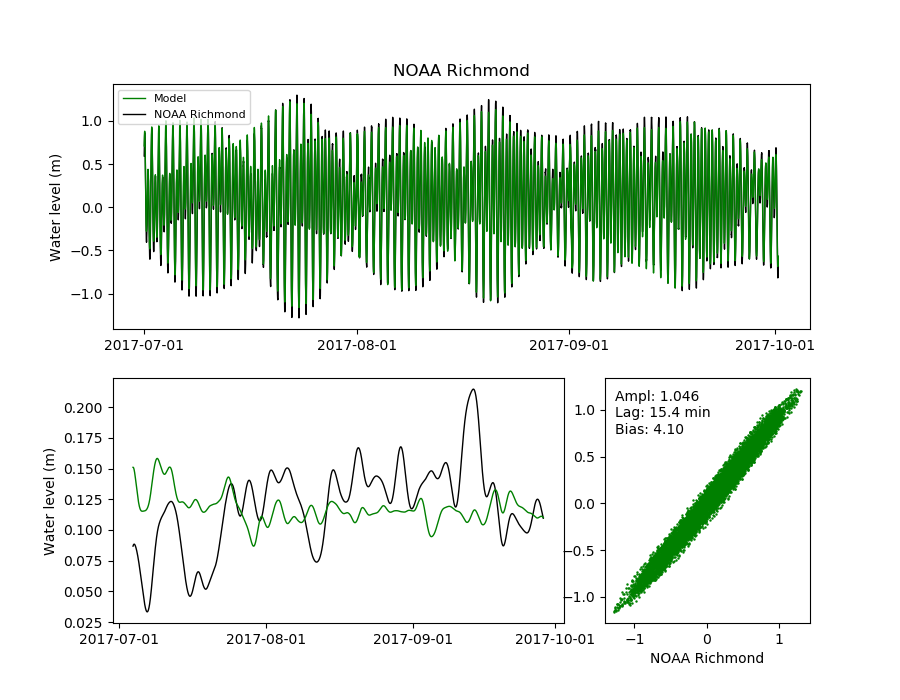

<IPython.core.display.Javascript object>


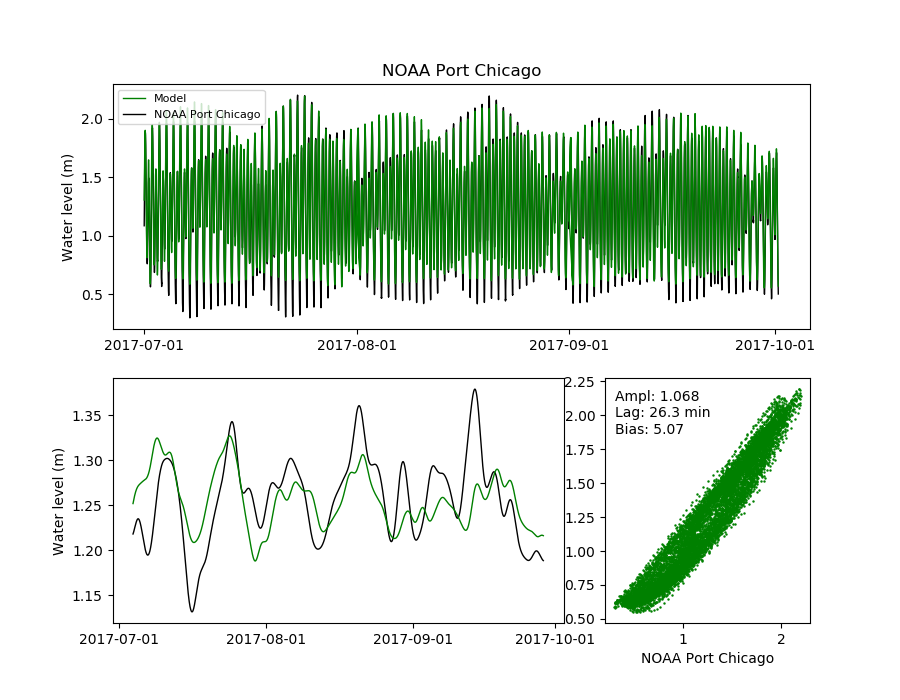

In [583]:
models=[modelA]
model_labels=[ os.path.basename(model.run_dir) for model in models]

for station in [alameda_wl,pointreyes_wl,sanfran_wl,coyote_wl,richmond_wl,
               portchicago_wl]:
    sources,combined=data_comparison.assemble_comparison_data(models,
                                                              [station],
                                                              model_labels=["Model"],
                                                             extract_options=dict(chain_count=start))
    fig=data_comparison.calibration_figure_3panel(sources,combined,scatter_x_source=1,offset_source=1,
                                  styles=[dict(color='g',lw=1.0,zorder=1),
                                          dict(color='k',lw=1.0,zorder=0),
                                          dict(color='0.7',zorder=-2,lw=0.5)])
    fig.axes[0].set_title(station.attrs['name'])
    for ax in fig.axes[:2]:
        ax.set_ylabel("Water level (m)")
    fig.savefig(os.path.join(fig_dir,"waterlevel-%s.png"%station.attrs['name'])) 


In [584]:
# Salinity vs. Polaris/Peterson
from stompy.io.local import usgs_sfbay
from stompy import xr_transect

In [585]:
six.moves.reload_module(usgs_sfbay)
# for now, show even the spinup period to see how things evolve
polaris=usgs_sfbay.usgs_sfbay_dataset(np.datetime64("2017-06-01"),
                                      end,cache_dir=cache_dir)

INFO:root:Will break that up into pieces
INFO:root:Cached 2017-06-01 00:00:00 -- 2017-07-01 00:00:00
INFO:root:Cached 2017-07-01 00:00:00 -- 2017-08-01 00:00:00
INFO:root:Cached 2017-08-01 00:00:00 -- 2017-09-01 00:00:00
INFO:root:Cached 2017-09-01 00:00:00 -- 2017-10-01 00:00:00
INFO:root:Cached 2017-10-01 00:00:00 -- 2017-11-01 00:00:00


<IPython.core.display.Javascript object>


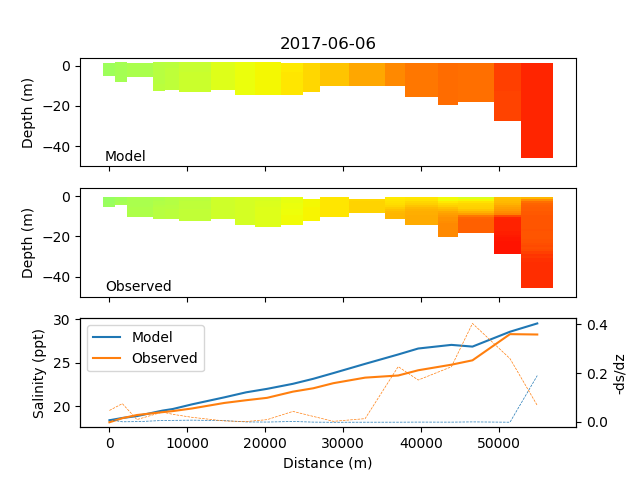

<IPython.core.display.Javascript object>


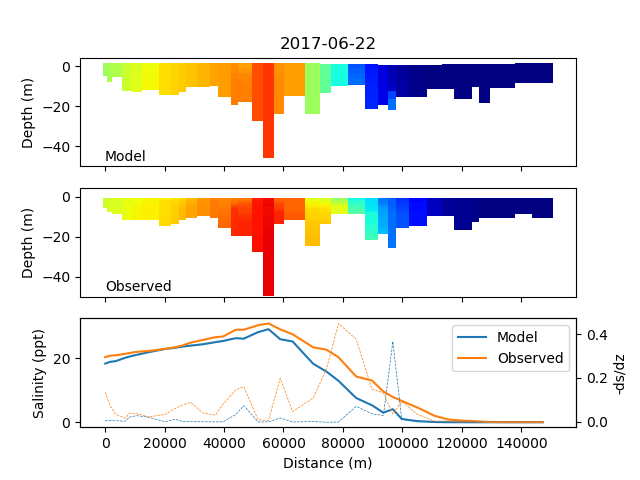

<IPython.core.display.Javascript object>


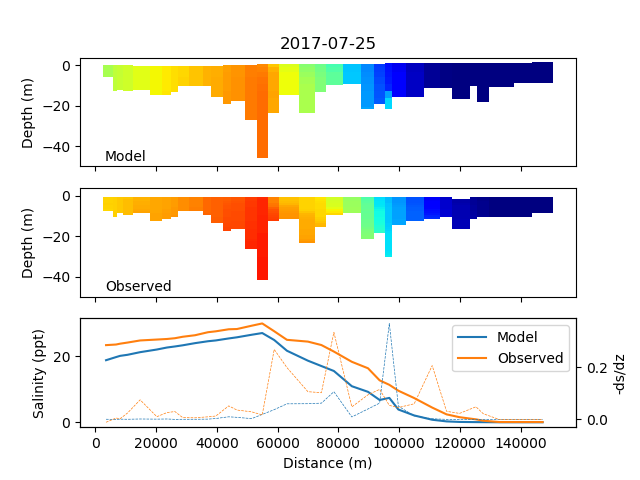

<IPython.core.display.Javascript object>


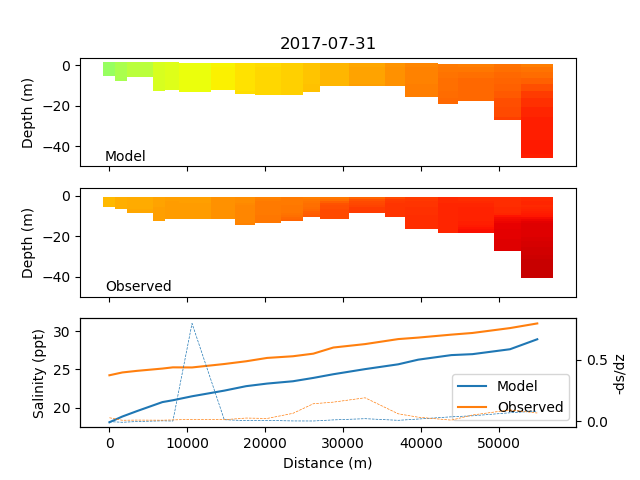

<IPython.core.display.Javascript object>


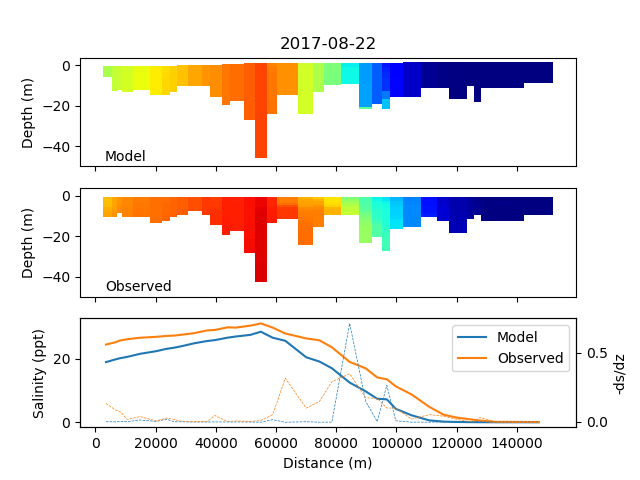

<IPython.core.display.Javascript object>


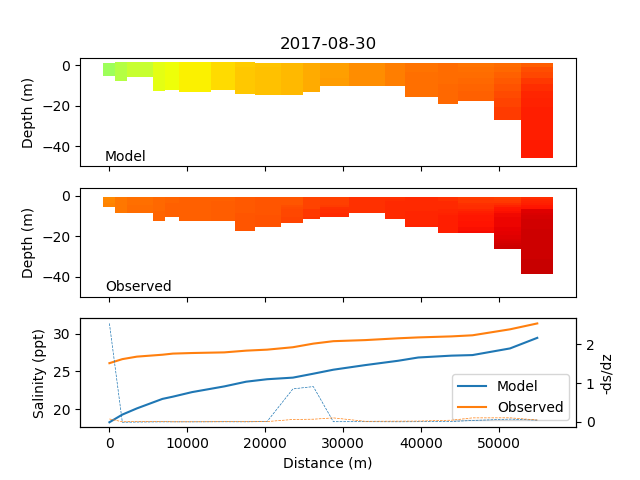

<IPython.core.display.Javascript object>


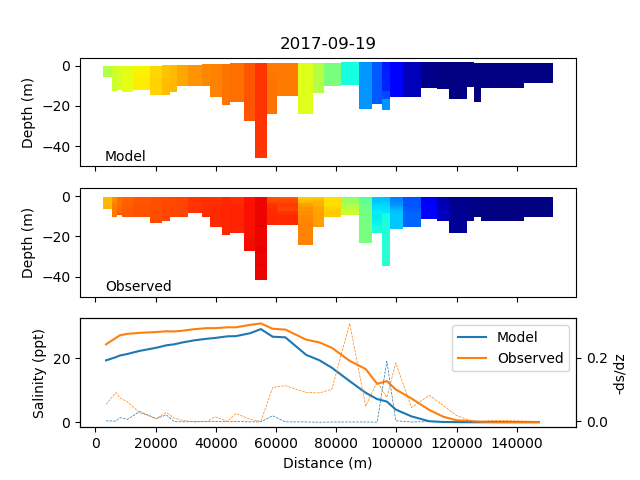

<IPython.core.display.Javascript object>


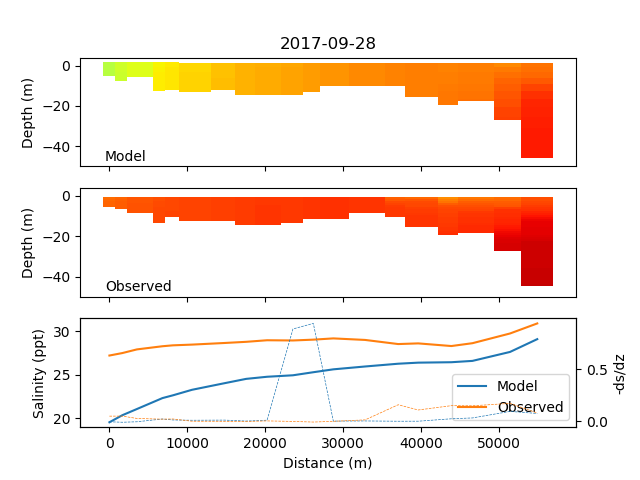

<IPython.core.display.Javascript object>


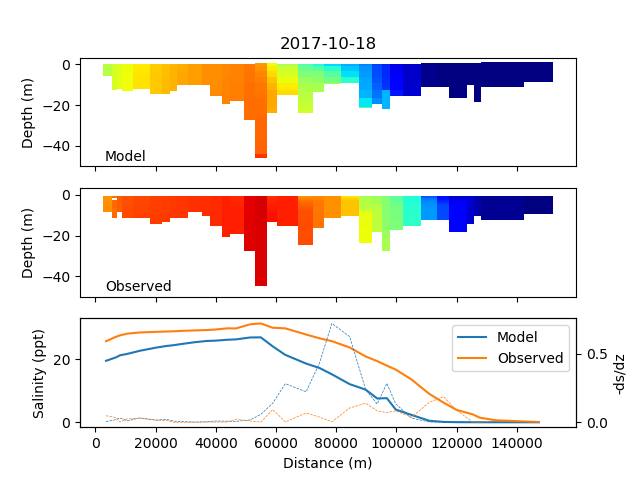

<IPython.core.display.Javascript object>


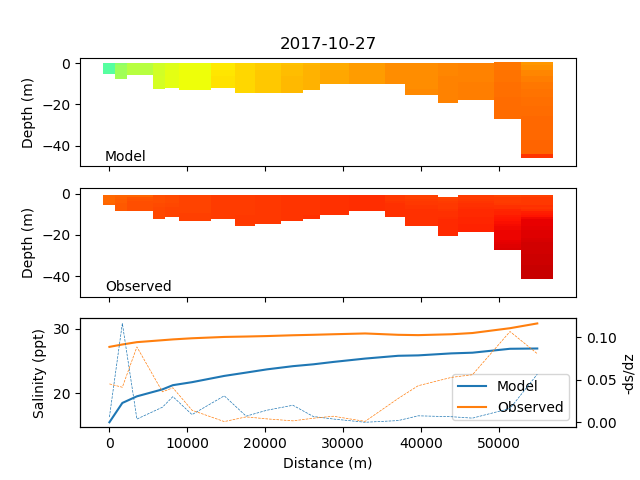

In [593]:
six.moves.reload_module(xr_transect)
import matplotlib.gridspec as gridspec


def plot_cruise(model,cruise):
    ll=np.c_[ cruise.longitude, cruise.latitude ]
    tran=modelA.extract_transect_monitor(ll=ll,time=cruise.time.values,dv_from_map=True)
    tran=tran.copy()

    for fld in ['eta','z_ctr','z_top','z_bot','dv']:
        if fld in tran:
            tran[fld] = tran[fld] + 5.0
    # by default d_sample is the calculated distance, but to match the
    # Polaris/Peterson data use the exact same values, which may not start
    # at 0.
    tran.d_sample.values[:]=cruise.d_sample.values
        
    fig=plot_transect_comparison([(tran,'salt'),
                                  (cruise,'Salinity')],
                                 labels=['Model','Observed'])
    return fig
    
def plot_transect_comparison(transects, labels=None):
    fig=plt.figure()
    gs = gridspec.GridSpec(len(transects)+1,1)

    if labels is None:
        labels=[str(i) for i in range(len(transects))]
        
    ax0=None
    for i,(tran,fld) in enumerate(transects):
        ax=fig.add_subplot(gs[i,0],sharex=ax0,sharey=ax0)
        if ax0 is None:
            ax0=ax
        polys=xr_transect.plot_scalar( tran, fld,cmap='jet',ax=ax, clim=[0,34])
        ax.text(0.05,0.05,labels[i],transform=ax.transAxes)
        plt.setp(ax.get_xticklabels(),visible=0)
        ax.set_ylabel('Depth (m)')

    axn=fig.add_subplot(gs[-1,0],sharex=ax0)
    axgrad=axn.twinx()
    
    for i,(tran,fld) in enumerate(transects):
        davg=xr_transect.depth_avg(tran,fld)
        axn.plot(tran.d_sample, davg,label=labels[i])
        fld_dz=xr_transect.d_dz(tran,fld)
        axgrad.plot(tran.d_sample,-fld_dz,ls='--',lw=0.5)
    axn.legend()
    axn.set_ylabel('Salinity (ppt)')
    axgrad.set_ylabel('-ds/dz')
    axn.set_xlabel('Distance (m)')
    
    ax0.axis(ymin=-50)
    ax0.set_title(utils.to_datetime(cruise.time.min()).strftime("%Y-%m-%d"))
    return fig


for cruise_i in range(polaris.dims['cruise']):
    cruise=polaris.isel(cruise=cruise_i)

    cruise=cruise.sortby('Distance from 36').sortby('depth')
    cruise['d_sample']=1000*cruise['Distance from 36']
    cruise['z_ctr']=-cruise['depth']
    cruise=cruise.rename(depth='layer')
    stn_sel=np.isfinite(cruise.Salinity.max(dim='layer'))
    cruise=cruise.isel(station=stn_sel)
    ll=np.c_[ cruise.longitude, cruise.latitude ]
    
    plot_cruise(modelA,cruise)
    date_str=utils.to_datetime(cruise.cruise.values).strftime("%Y-%m-%d")
    fig.savefig(os.path.join(fig_dir,"polaris-%s.png"%date_str))


'2017-06-06'